<a href="https://colab.research.google.com/github/kfrancis2017/csce556-labs/blob/main/CSCE556_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCE 556 - Data Analysis in Python: Application to Neuroscience

## Laboratory 5 - Time-series and signal processing

This laboratory illustrates a few concepts of signal processing. More precisely, it uses Python libraries (`numpy` and `matplotlib` for data analysis and `scipy` to import/export WAV files) to perform some basic sound processing functions. It uses normal audio files to make the laboratory hopefully more fun and relatable. Please keep in mind that many sources of data signals (e.g., biosignals, machine sensors, instruments, etc.) just like sounds and are, therefore, processed using the same concepts.

Read the explanations and run the cells one by one. Turn the volume of your computer on to hear the sound.

**Note**: This notebook is adapted from [a notebook from Eugene Klyshko from the University of Toronto](https://github.com/klyshko/signal_processing/tree/master).

We’ll begin by importing the necessary packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

Setting the size and resolution of matplotlib images see better quality graphs.

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)

We now download and unzip the data we will use.

In [6]:
import requests
from zipfile import ZipFile

file_url = "https://www.dropbox.com/scl/fi/1cprymlz21arsjr22t3te/sound_data.zip?rlkey=3j2dvp8ksubxyfn94crokjqv7&dl=1"

r = requests.get(file_url, stream = True)

with open("data.zip", "wb") as file:
    for block in r.iter_content(chunk_size = 1024):
         if block:
             file.write(block)

with ZipFile("data.zip", 'r') as zObject:
    zObject.extractall(path="./")

Next we read in a wav file. It contains a note **A3#** played by piano and recorded with digital microphone. The fundamental frequency (F0) of this note is **233.8 Hz**. Googling "note frequency chart" you will easily find charts showing the correspondance between notes and frequencies.

In [7]:
samp_freq, sound = wavfile.read('data/noise_a3s.wav')

You can download the file to your computer and play it. You can hear the characteristic background noise of a low frequency. We will try to remove this noise from the signal and obtain a clearer sound.


### Digital sound
When you hear a sound, your ear's membrane oscillates because the density and pressure of the air in close proximity to the ear oscillate as well. Thus, sound recordings contain the relative signal of these oscilations. Digital audio recordings are sounds that have been recorded in, or converted into, digital form. In digital audio, the sound wave of the audio signal is encoded as numerical samples in continuous sequence. For example, WAV files are often sampled 44,100 times per second each with 16 bit sample depth, i.e. there are 2^16 = 65536 possible values of the signal: from -32768 to 32767. For the example below, a sound wave, in red, represented digitally, in blue (after sampling and 4-bit quantization).

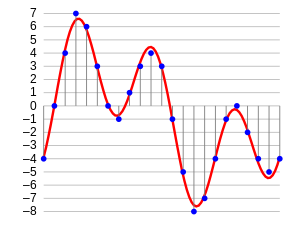

Typically, stereo **wav**-file contains two arrays of integers: for the right and left channel (for your right and left speaker), respectively.

The `scipy.io.wavfile.read()` function reads wav files as `int16` (for 16-bit wavs) or `int32` (for 32-bit wavs), 24-bit wav files are not supported. We can check these properties for a specific recording as follows:

In [5]:
sound.dtype, samp_freq

(dtype('int16'), 44100)

This means that the sound pressure values are mapped to integer values that can range from -2^15 to (2^15)-1. The samples are taken 44,100 times per second.

We can convert our sound (numpy) array to floating point values ranging from -1 to 1 as follows:

In [8]:
sound = sound / 2.0**15

Now let's see the shape of the sound array. The wav file has two channels and 45,568 sample points

In [9]:
sound.shape

(45568, 2)

Considering the sampling rate (`samp_freq = 44110`) this corresponds to a duration of around 1.03 seconds

In [10]:
length_in_s = sound.shape[0] / samp_freq
print(length_in_s)

1.0332879818594105


### Plotting the sound signal on each channel

A time representation of the sound can be obtained by plotting the pressure values against the time axis.

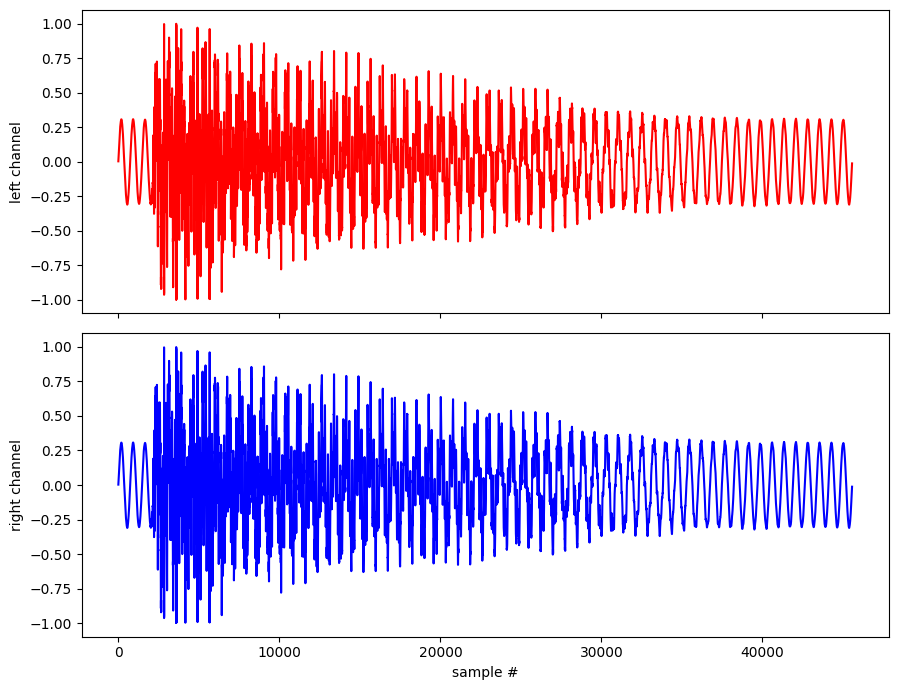

In [11]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(sound[:,0], 'r')
axes[0].set_ylabel("left channel")

axes[1].plot(sound[:,1], 'b')
axes[1].set_xlabel("sample #")
axes[1].set_ylabel("right channel")

fig.tight_layout()


However, we need to create an array containing the time points first. To get the proper time on the x-axis we have to generate a numpy array using `samp_freq`:

In [12]:
time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s

Now let's look at the proper axis titles:

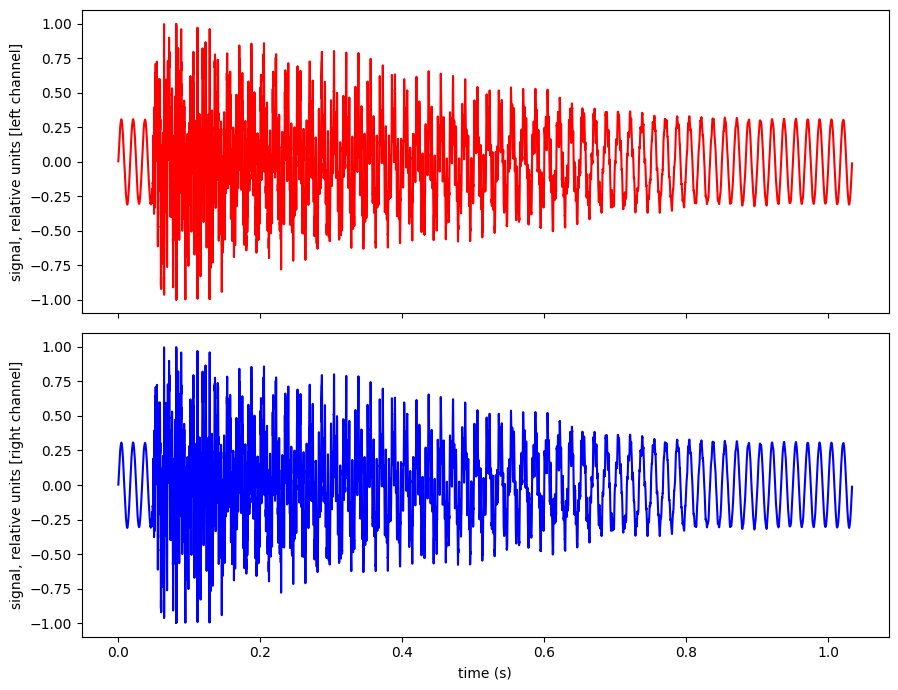

In [13]:
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(time, sound[:,0], 'r')
axes[0].set_ylabel("signal, relative units [left channel]")

axes[1].plot(time, sound[:,1], 'b')
axes[1].set_xlabel("time (s)")
axes[1].set_ylabel("signal, relative units [right channel]")

fig.tight_layout()

We will select and work with only one of the channels from now on

In [14]:
signal = sound[:,0]

We see a lot of oscillations and it is all pretty messy. We want to look at the sound with a higher resolution:

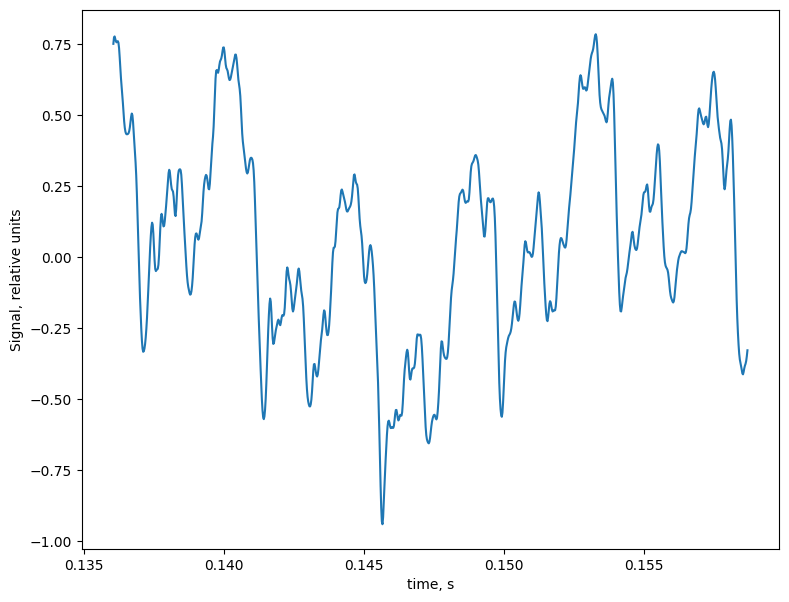

In [15]:
plt.plot(time[6000:7000], signal[6000:7000])
plt.xlabel("time, s")
plt.ylabel("Signal, relative units");

Yes, this is how your ear membrane oscillates on a microsecond timescale...

### Plotting the frequency content with FT
Another useful graphical representation is that of the frequency content, or spectrum of the note. The standard way of doing that is with a **discrete Fourier transform** (https://en.wikipedia.org/wiki/Discrete_Fourier_transform) using the **fast Fourier transform** (https://en.wikipedia.org/wiki/Fast_Fourier_transform) or FFT algorithm. Basically, we take a sound signal and isolate the frequencies of sine waves that make up that sound.

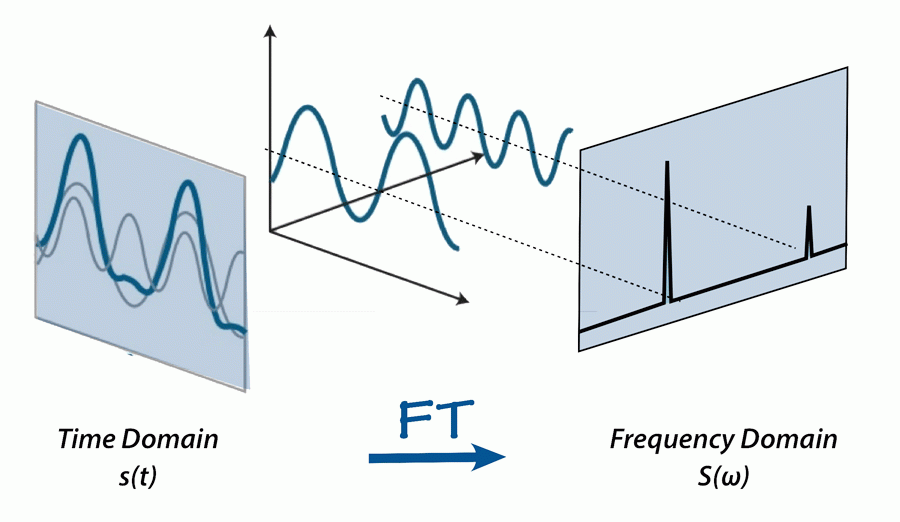

For this purpose, we are going to use the `np.fft.rfft()` function. This is functions works with real values only (i.e., not complex numbers). The function `np.fft.rfftfreq()` works together with `np.fft.rfft()` and provides the corresponding frequencies in Hz:

In [16]:
fft_spectrum = np.fft.rfft(signal)
freq = np.fft.rfftfreq(signal.size, d=1./samp_freq)

The FFT of the data is usually complex:

In [17]:
fft_spectrum

array([36.86898804 +0.j        , 30.28378521-20.33641395j,
       12.91719742-33.17116609j, ...,  1.4172224  +1.4045349j ,
        1.8525152  +0.76925206j,  1.99081421 +0.j        ])

To simplify the concept without going deeply into the theorical part, let us say that when we performe the fft to get `X = fft(x)`, we usually need to use the signal magnitude in the spectral domain: `A = |X| = sqrt(real(X)^2+ imag(X)^2)`. The phase of the signal can also be computed using: `Phi = phase(X) = arctan(imag(X)/real(X))`. We will not use the phase for this laboratory, but it is sometime important for signal processing applications (e.g., differences in phases between signals picked up by different EEG electrodes are used to assess how different regions of the brain are connected). To obtain the amplitude from the spectrum we compute the absolute value of the fourier transform:

In [18]:
fft_spectrum_abs = np.abs(fft_spectrum)

Thus, the spectrum of the sound (frequency domain) looks like:

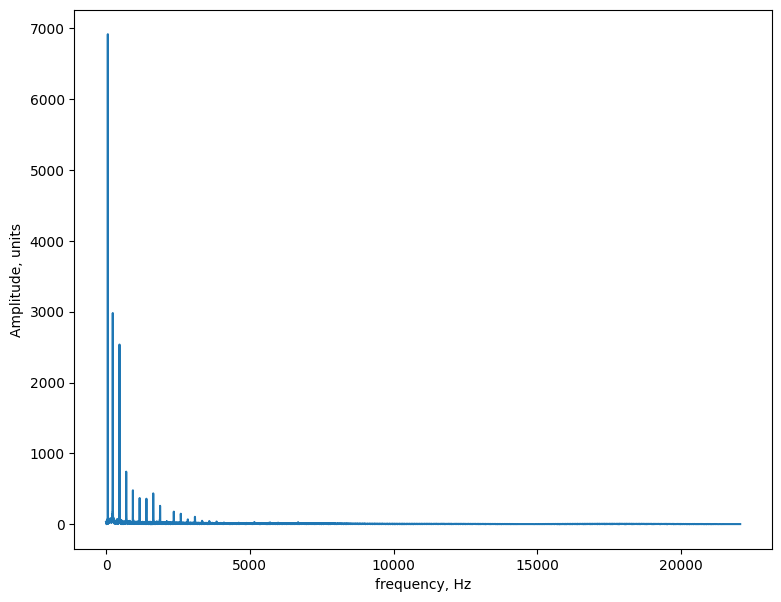

In [19]:
plt.plot(freq, fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

Humans can hear sounds in the 20-20,000 Hz range. However, our sound does not contain frequencies greater than 3 kHz. Let us zoom in on the highest peaks:

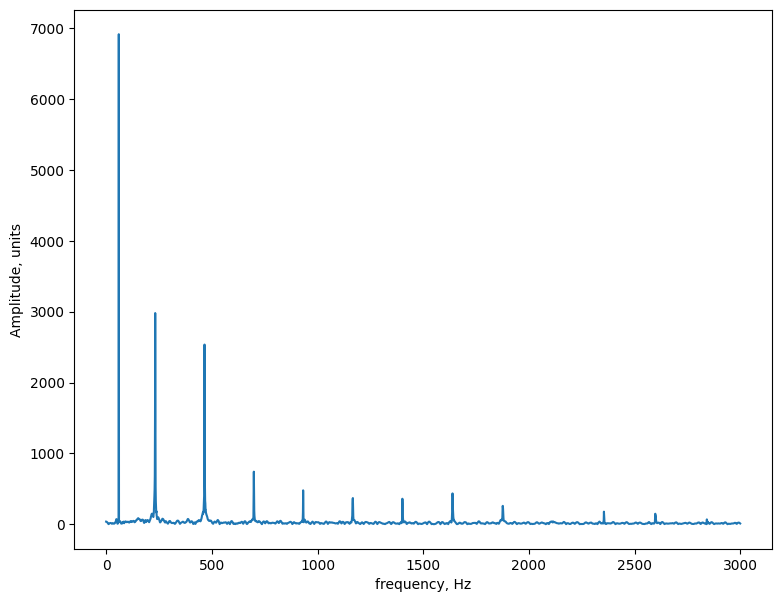

In [20]:
plt.plot(freq[freq <= 3000], fft_spectrum_abs[freq <= 3000])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

We see a lot of equally spaced peaks, and the distance between them is ~235 Hz. Let us zoom in even more:

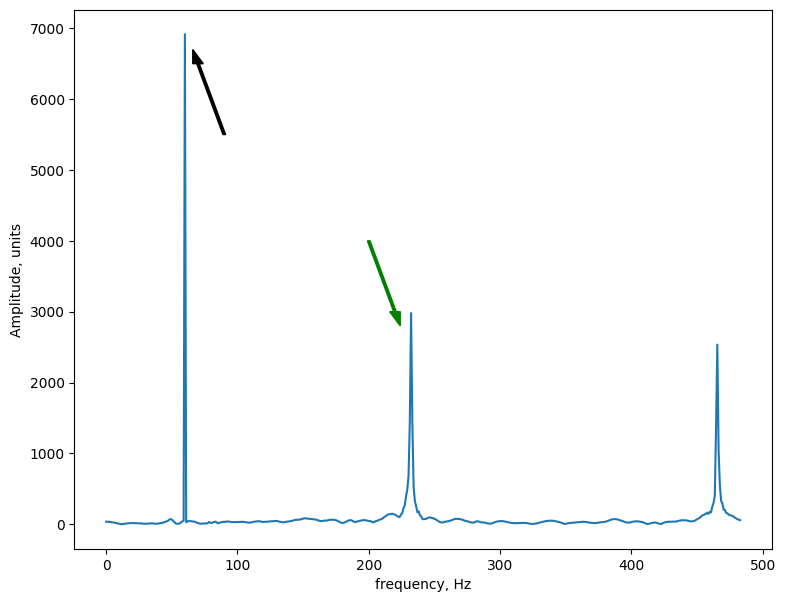

In [21]:
plt.plot(freq[:500], fft_spectrum_abs[:500])
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.arrow(90, 5500, -20, 1000, width=2, head_width=8, head_length=200, fc='k', ec='k')
plt.arrow(200, 4000, 20, -1000, width=2, head_width=8, head_length=200, fc='g', ec='g')
plt.show()

The plot shows one big spike at 60 Hz (black arrow). This is the frequency used for the alternating current (power line) in North America where, probably, the recording was made, and it is very noticable when you play a sound. If this recording was made in Europe, for example, this peak would be at 50 Hz. Such power line contamination is often present in biosignal recordings and need to be corrected for by using a *notch filter*.

For sound recordings, this effect is called **electric hum** ([more details](https://en.wikipedia.org/wiki/Mains_hum)). In short, because of the ubiquitous AC electromagnetic fields from nearby appliances and wiring, 60 Hz electrical noise can get into audio systems. This reaches the microphone and is recorded. When recording using the built-in microphone on a laptop, a good way to prevent this is to disconnect the battery charger when recording.

The second highest peak is called a fundamental frequency (green arrow) - and it's near **233 Hz**. The other spikes are called harmonics and are multiples of the fundamental frequency. We see that except 60 Hz noise, there are spikes around 233 Hz, 465 Hz, 698 Hz, 932 Hz, 1167 Hz, 1401 Hz and 1638 Hz (all are multiples of ~233 Hz).

For music lovers: our sound is a **semitone A** of the third octave (or **A3#**) geneated by a piano. Let us look at all the peaks more thoroughly:

In [22]:
from scipy.signal import find_peaks

# looking at amplitudes of the spikes higher than 350
peak_inds = find_peaks(fft_spectrum_abs, height=350)[0]
for i in peak_inds:
  print('frequency = {} Hz with amplitude {} '.format(np.round(freq[i],1),  np.round(fft_spectrum_abs[i])))

frequency = 60.0 Hz with amplitude 6916.0 
frequency = 232.3 Hz with amplitude 2981.0 
frequency = 465.5 Hz with amplitude 2536.0 
frequency = 698.7 Hz with amplitude 742.0 
frequency = 932.0 Hz with amplitude 478.0 
frequency = 1167.1 Hz with amplitude 369.0 
frequency = 1401.4 Hz with amplitude 360.0 
frequency = 1638.5 Hz with amplitude 435.0 


Note that `SciPy`'s function `find_peaks` finds isolated peaks, i.e., it does not return the indices of closest neighbors which are also above the threshold value. Compare with the following code:

In [23]:
peak_inds = np.where(fft_spectrum_abs >= 350)[0]
for i in peak_inds:
  print('frequency = {} Hz with amplitude {} '.format(np.round(freq[i],1),  np.round(fft_spectrum_abs[i])))

frequency = 60.0 Hz with amplitude 6916.0 
frequency = 228.4 Hz with amplitude 392.0 
frequency = 229.4 Hz with amplitude 487.0 
frequency = 230.3 Hz with amplitude 683.0 
frequency = 231.3 Hz with amplitude 1446.0 
frequency = 232.3 Hz with amplitude 2981.0 
frequency = 233.2 Hz with amplitude 1438.0 
frequency = 234.2 Hz with amplitude 524.0 
frequency = 463.6 Hz with amplitude 397.0 
frequency = 464.5 Hz with amplitude 1379.0 
frequency = 465.5 Hz with amplitude 2536.0 
frequency = 466.5 Hz with amplitude 1045.0 
frequency = 467.4 Hz with amplitude 548.0 
frequency = 697.8 Hz with amplitude 420.0 
frequency = 698.7 Hz with amplitude 742.0 
frequency = 699.7 Hz with amplitude 386.0 
frequency = 932.0 Hz with amplitude 478.0 
frequency = 1166.2 Hz with amplitude 354.0 
frequency = 1167.1 Hz with amplitude 369.0 
frequency = 1401.4 Hz with amplitude 360.0 
frequency = 1638.5 Hz with amplitude 435.0 
frequency = 1639.4 Hz with amplitude 378.0 


The way to filter the electric hum sound is to set the amplitudes of the FFT values around 60 Hz to 0, see (1) in the code below. In addition to filtering this peak, we will also remove the frequencies below the human hearing range and above the normal human voice range (2).

In [24]:
for i,f in enumerate(freq):
    if f < 62 and f > 58:        # (1)
        fft_spectrum[i] = 0.0
    if f < 21 or f > 20000:      # (2)
        fft_spectrum[i] = 0.0

Let us look again on the spectrum.

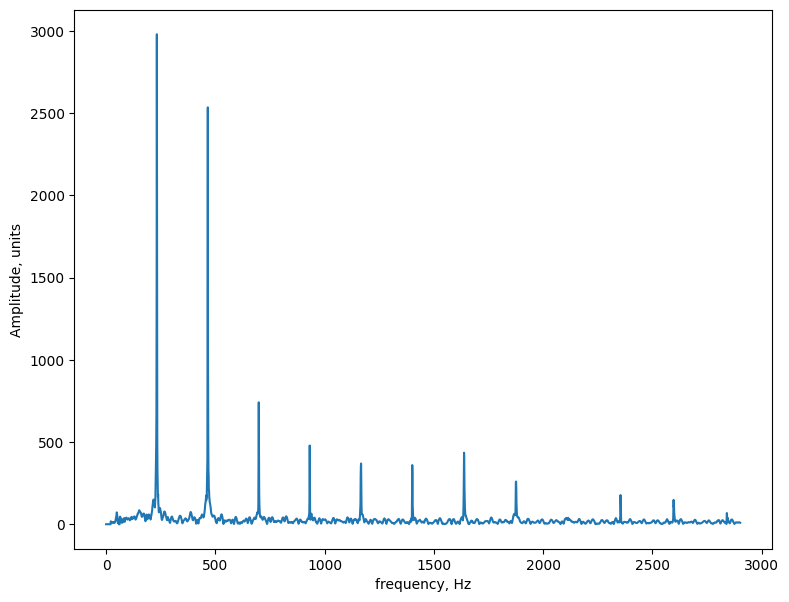

In [25]:
plt.plot(freq[:3000], np.abs(fft_spectrum[:3000]))
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

We see no spikes in the 60 Hz region. Then we recreate the original signal via an inverse FFT:

In [26]:
noiseless_signal = np.fft.irfft(fft_spectrum)

Let us save the noiseless sound in a file, download it from the jupyterhub folder and play it in iTunes (can you hear a difference?):

In [27]:
wavfile.write("data/noiseless_a3s.wav", samp_freq, noiseless_signal)

## Problem 1.

The wav file called `data/unknown.wav` contains the sound of a note played on a piano and recorded without AC noise. Find the fundamental frequency and determine the corresponding note (i.e., A, B, C, ..., F). Look up on the Internet to find what notes correspond to what frequencies.

In [33]:
#### Add your code ####
samp_freq2, sound2 = wavfile.read('data/unknown.wav')
sound = sound / 2.0**15
signal = sound[:,0]
fft_spectrum = np.fft.rfft(signal)
freq = np.fft.rfftfreq(signal.size, d=1./samp_freq2)
fft_spectrum_abs = np.abs(fft_spectrum)
#######################

## Problem 2.

In the `data/unknown.wav` find the fundamental frequency and remove all the overtones from the Fourier spectrum. Plot the modified spectrum overlaid with the original spectrum to confirm that you successfully removed the overtones. Save the modified sound with the filename `data/no_overtones.wav`.

In [ ]:
#### Add your code ####

#######################

If you'd like, you can listen to the original and the modified sounds by running this code. If you cannot hear any sounds, it means you probably did not save the file correctly!

In [28]:
from IPython.display import Audio, display
display(Audio("data/unknown.wav", autoplay=False))
display(Audio("data/no_overtones.wav", autoplay=False))

ValueError: rate must be specified when data is a numpy array or list of audio samples.